In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-04-29 12:55:16.716363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+2']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+2'

y_col='DST+2'
valid_size = int(len(train) * 0.25)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [3]:
n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1068
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [14]:
model = keras.models.load_model('2h_dopredu200.hdf5')

In [15]:
# prediction
y_pred = model.predict(test_generator)

610/610 [==============================] - 9s 14ms/step


Confusion matrix: 
[[119154   6259]
 [  7948  22749]]


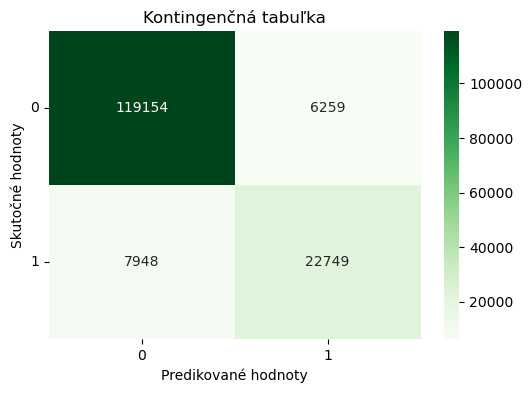

In [16]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [17]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94    125413
           1       0.78      0.74      0.76     30697

    accuracy                           0.91    156110
   macro avg       0.86      0.85      0.85    156110
weighted avg       0.91      0.91      0.91    156110



In [9]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [10]:
df.describe()

,y_true,y_predict
count,156110.000000,156110.000000
mean,-9.785055,-9.424089
std,16.323784,15.716485
min,-374.000000,-358.097290
25%,-16.000000,-15.783654
50%,-7.000000,-6.628311
75%,0.000000,0.044060
max,77.000000,52.561642


<AxesSubplot:>

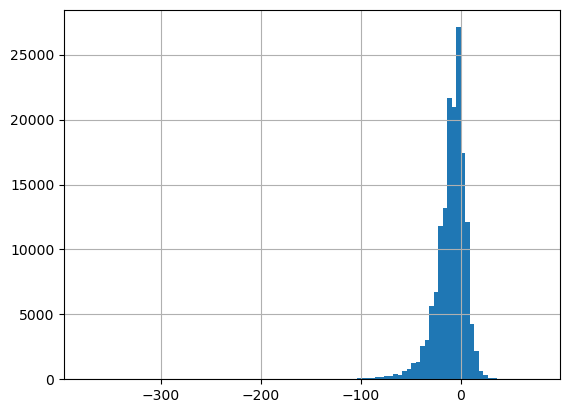

In [11]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

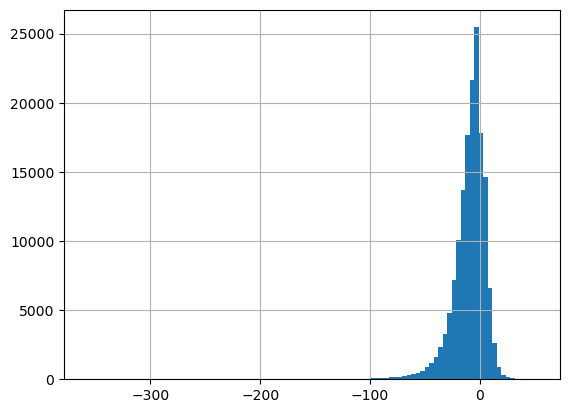

In [12]:
df["y_predict"].hist(bins=100)

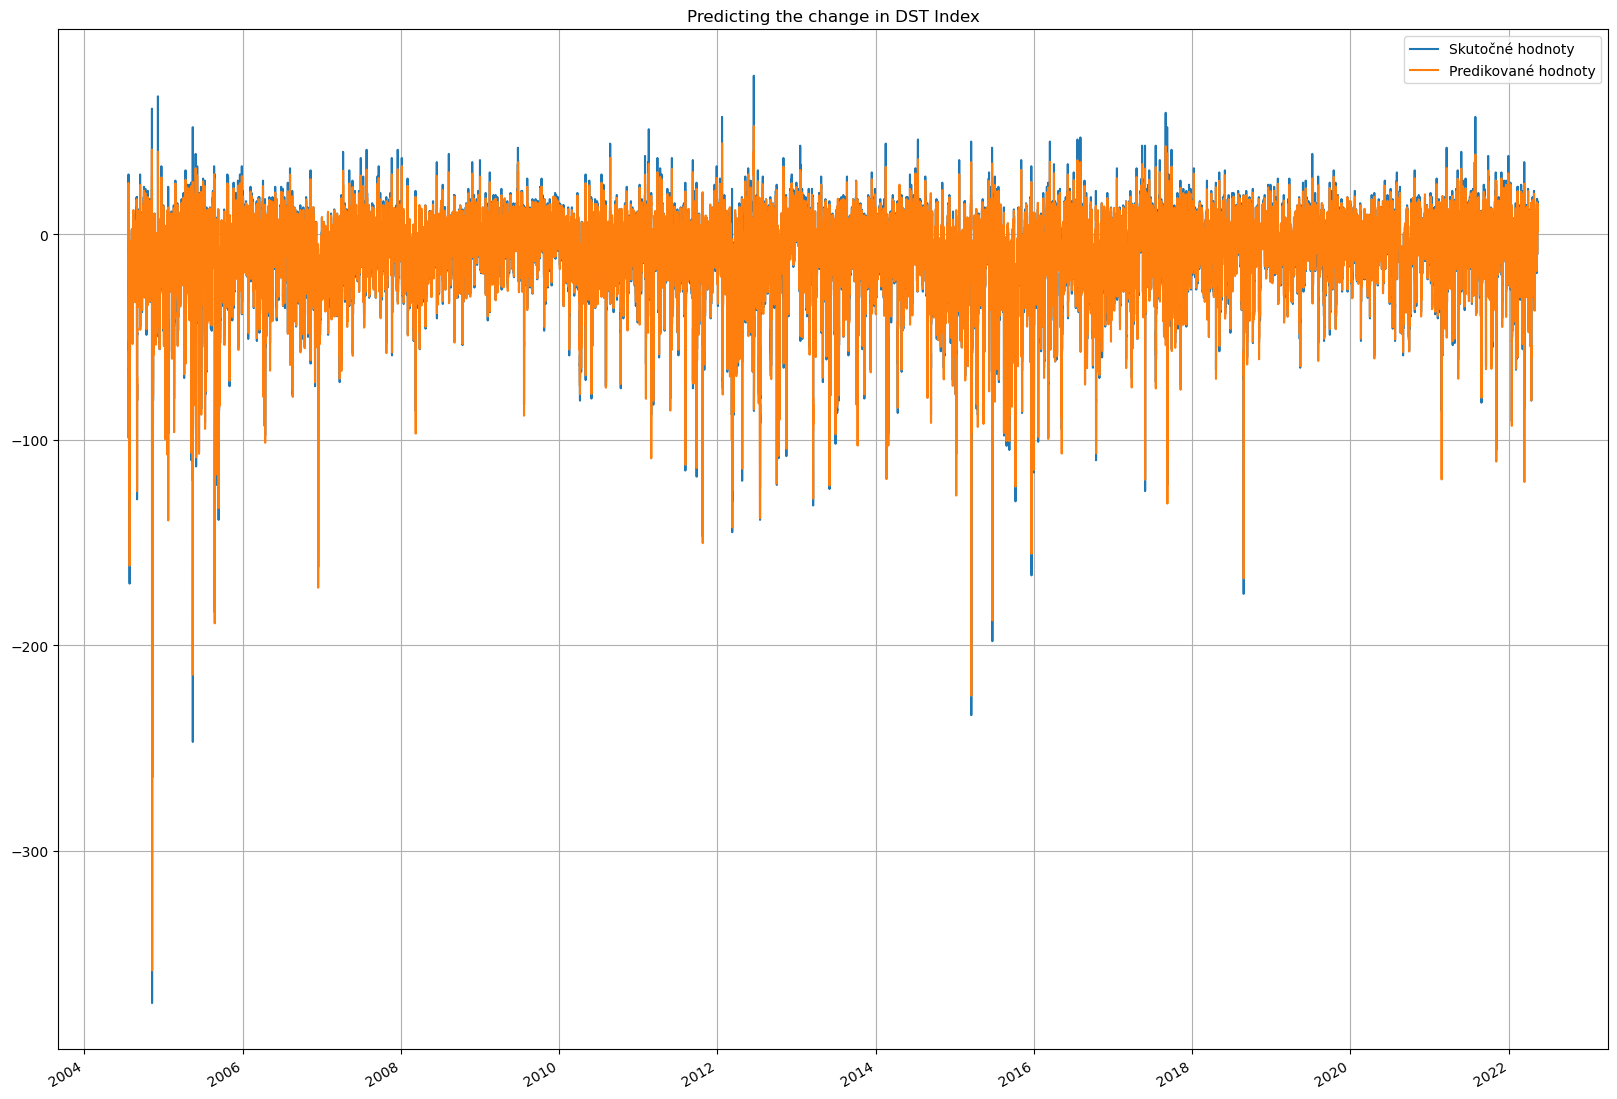

In [14]:
plt.figure(figsize=(20, 15))
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

# Vysvetliteľnosť modelu na základe DST indexu 1h dopredu 6 dozadu

In [15]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [16]:
#hodnota pre vypínanie intervalov priemer
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.784205334494862

In [17]:
#hodnota pre vypínanie intervalov median
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

In [18]:
def XAI_for_DST_Prediction(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-5,1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [19]:
def XAI_for_DST_Prediction_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,2)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+2],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 18ms/step


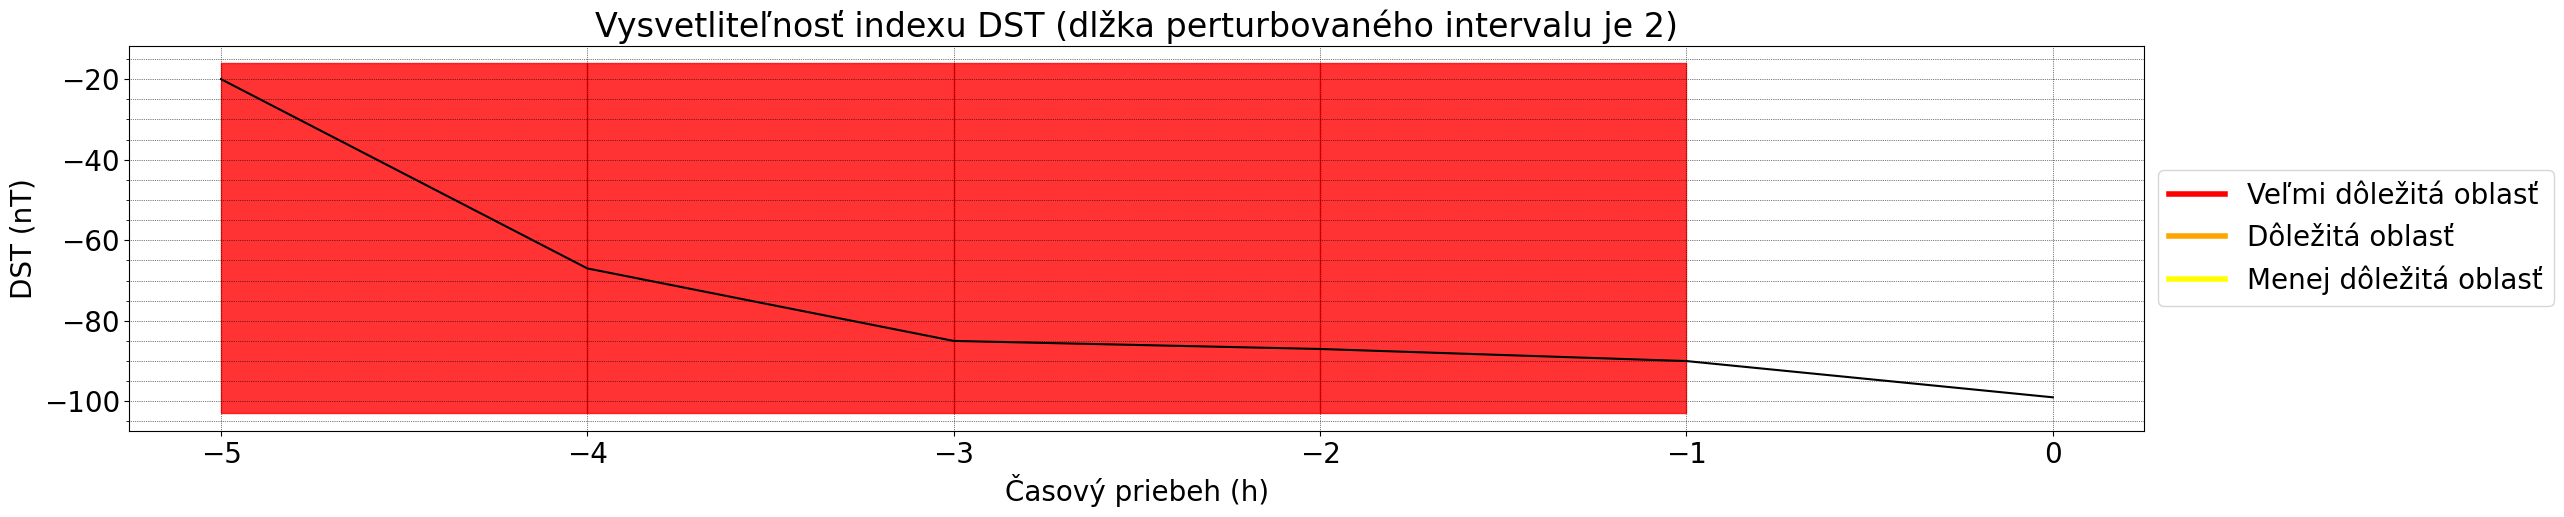

In [20]:
XAI_for_DST_Prediction(test_generator[0][0][24], model,2, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


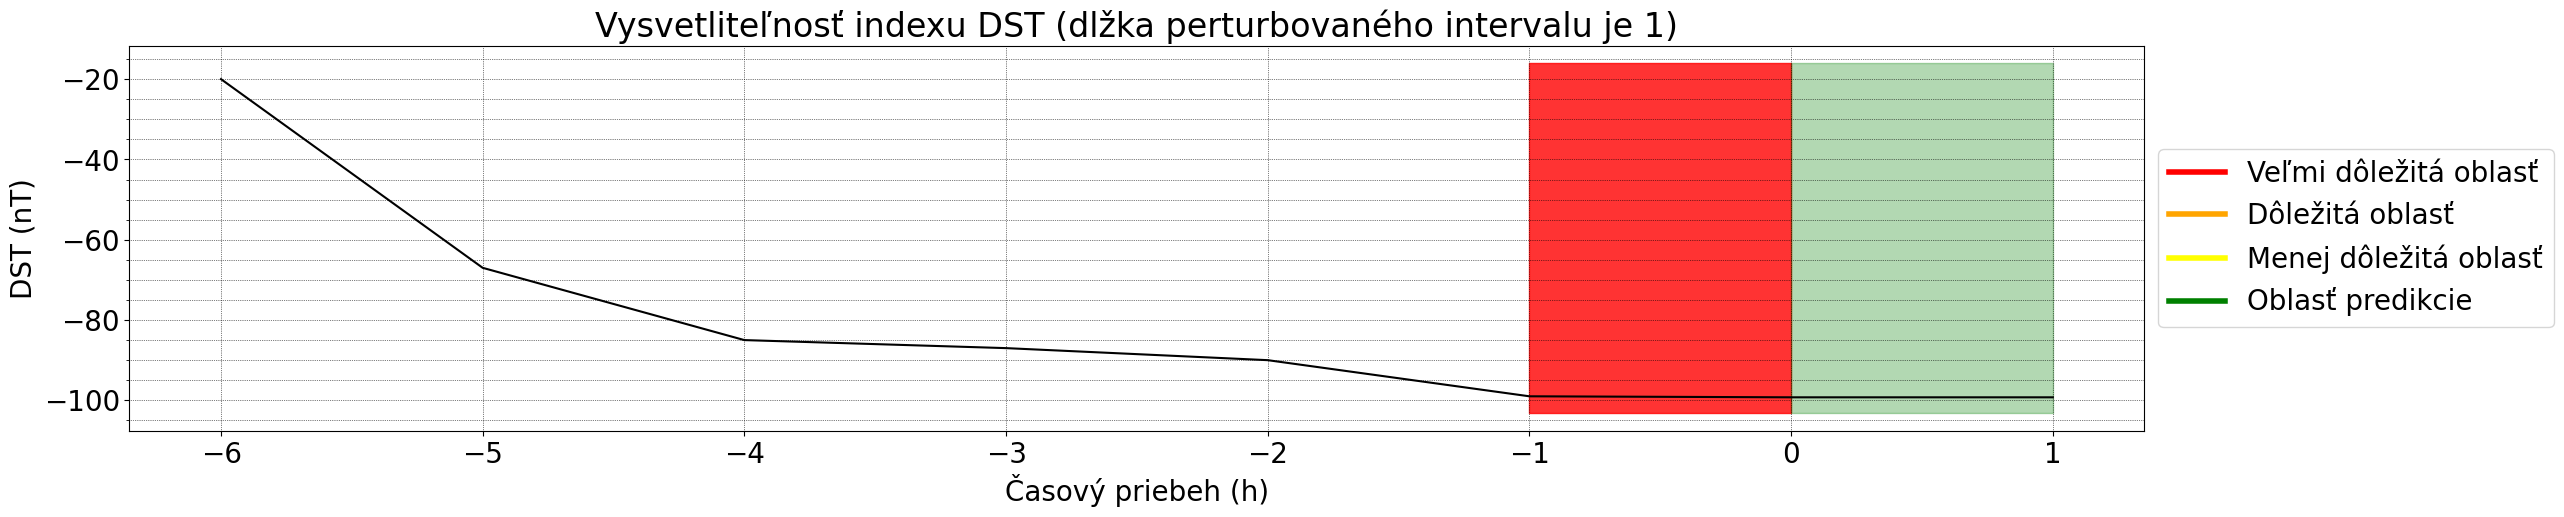

In [21]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][24], model,1, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


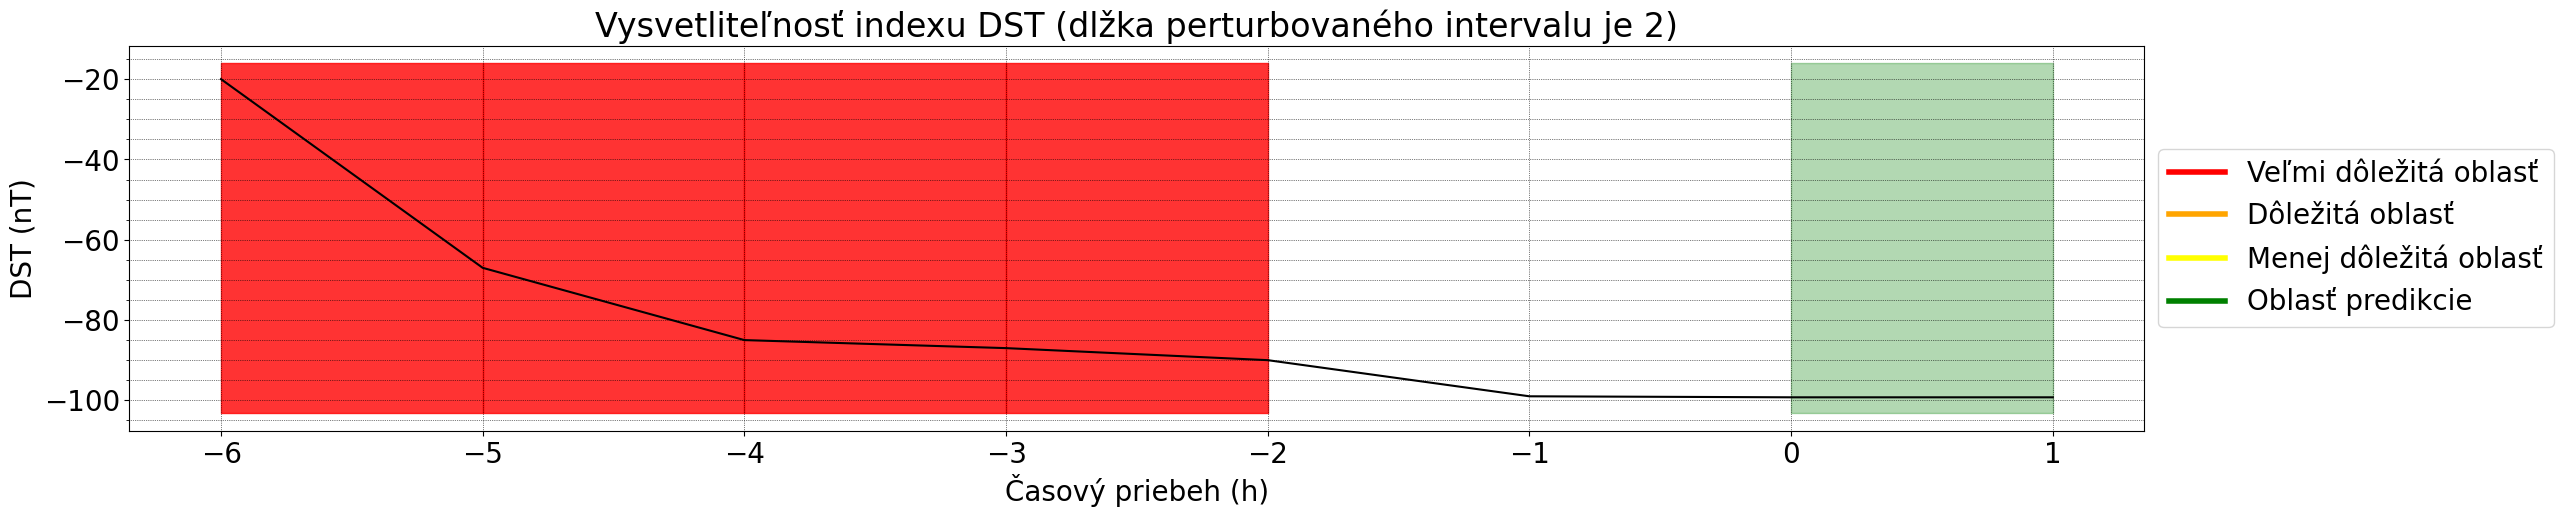

In [22]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][24], model,2, value_for_shutdown)